# Bayesian biodiversity: Model data analysis

In [2]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [115]:
# Load black for formatting
import jupyter_black

jupyter_black.load()

In [116]:
# sns.set_style("darkgrid", {"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_style("dark")
sns.set()
pl.Config.set_tbl_rows(100);

## Load data, filter scope and select covariates to analyze

In [3]:
# Load all of the data
df = pl.read_parquet("../../data/output/abundance/abundance_all_species.parquet")

In [4]:
df.shape

(26761, 152)

In [119]:
df.head()

shape: (5, 151)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ SS        ┆ SSB       ┆ SSBS      ┆ Abundance ┆ … ┆ Mean_pop_ ┆ Mean_pop_ ┆ Mean_pop_ ┆ Mean_pop │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ density_1 ┆ density_5 ┆ density_5 ┆ _density │
│ str       ┆ str       ┆ str       ┆ f64       ┆   ┆ 0km_cbrt  ┆ 0km_log   ┆ 0km_sqrt  ┆ _50km_cb │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ rt       │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ AD1_2002_ ┆ AD1_2002_ ┆ AD1_2002_ ┆ 49.0      ┆ … ┆ 8.234581  ┆ 5.856194  ┆ 18.665287 ┆ 7.036493 │
│ _Kruess 1 ┆ _Kruess 1 ┆ _Kruess 1 ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 4         ┆           ┆   ┆           ┆           ┆           ┆          │
│ AD1_2002_ ┆ AD1_2002_ ┆ AD1_2002_ ┆ 58.0      ┆ … ┆ 8.234581  ┆ 5.856194  ┆ 18.665287 ┆ 7.036493 │
│ _Kruess 1 ┆ _Kruess 1 ┆ _Kruess 1 ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 7         ┆           ┆   ┆           ┆           ┆           ┆          │
│ AD1_2002_ ┆ AD1_2002_ ┆ AD1_2002_ ┆ 24.0      ┆ … ┆ 8.234581  ┆ 5.856194  ┆ 18.665287 ┆ 7.036493 │
│ _Kruess 2 ┆ _Kruess 2 ┆ _Kruess 2 ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 3         ┆           ┆   ┆           ┆           ┆           ┆          │
│ AD1_2002_ ┆ AD1_2002_ ┆ AD1_2002_ ┆ 13.0      ┆ … ┆ 8.234581  ┆ 5.856194  ┆ 18.665287 ┆ 7.036493 │
│ _Kruess 2 ┆ _Kruess 2 ┆ _Kruess 2 ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 5         ┆           ┆   ┆           ┆           ┆           ┆          │
│ AD1_2002_ ┆ AD1_2002_ ┆ AD1_2002_ ┆ 79.0      ┆ … ┆ 8.227003  ┆ 5.856493  ┆ 18.66809  ┆ 7.037198 │
│ _Kruess 3 ┆ _Kruess 3 ┆ _Kruess 3 ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 17        ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [5]:
df.get_column("Max_scaled_abundance").equals(df.get_column("Max_scaled_mean_abundance"))

False

In [121]:
for col in df.columns:
    try:
        nan_count = df.get_column(col).is_nan().sum()
        inf_count = df.get_column(col).is_infinite().sum()
        if nan_count > 0:
            print(f"{col}: {nan_count}")
        if inf_count > 0:
            print(f"{col}: {inf_count}")
    except pl.InvalidOperationError:
        continue

In [6]:
# Filter the biogeographical scope
scope = {
    "Biome": [
        "Tropical & Subtropical Moist Broadleaf Forests",
        "Tropical & Subtropical Dry Broadleaf Forests",
        "Tropical & Subtropical Coniferous Forests",
    ],
}

df_scope = df.clone()
for col in scope.keys():
    df_scope = df_scope.filter(pl.col(col).is_in(scope[col]))

In [7]:
df_scope.shape

(7732, 152)

In [168]:
df_scope.columns

['SS',
 'SSB',
 'SSBS',
 'Abundance',
 'Study_max_abundance',
 'Max_scaled_abundance',
 'Mean_abundance',
 'Study_max_mean_abundance',
 'Max_scaled_mean_abundance',
 'Species_richness',
 'Study_max_richness',
 'Max_scaled_species_richness',
 'Longitude',
 'Latitude',
 'Country',
 'UN_region',
 'UN_subregion',
 'Realm',
 'Biome',
 'Ecoregion',
 'Wilderness_area',
 'Hotspot',
 'Sample_midpoint',
 'Sampling_method',
 'Sampling_effort',
 'Rescaled_sampling_effort',
 'Max_linear_extent_metres',
 'Diversity_metric_type',
 'Predominant_land_use',
 'Use_intensity',
 'Habitat_patch_area_square_metres',
 'Km_to_nearest_edge_of_habitat',
 'Years_since_fragmentation_or_conversion',
 'Road_density_1km',
 'Road_density_10km',
 'Road_density_50km',
 'Pop_density_1km',
 'Pop_density_10km',
 'Pop_density_50km',
 'Annual_mean_temp_1km',
 'Temp_seasonality_1km',
 'Max_temp_warmest_month_1km',
 'Min_temp_coldest_month_1km',
 'Annual_precip_1km',
 'Precip_wettest_month_1km',
 'Precip_driest_month_1km',
 'P

In [124]:
response_var = "Max_scaled_abundance"

In [125]:
def correlation_scatter_plots(df, response, covariates):
    df = df.to_pandas()

    sns.set_style("dark")
    sns.set()

    # Set the figsize dynamically based on the number of covariates
    n_rows, n_cols = 3, 2
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True
    )

    # Ensure axs is always a 2D array for consistent indexing, even with a single subplot
    if n_rows == 1 and n_cols == 1:
        axs = np.array([[axs]])
    elif n_rows == 1 or n_cols == 1:
        axs = axs.reshape(n_rows, n_cols)

    for i, covariate in enumerate(covariates):
        ax = axs[i // n_cols, i % n_cols]

        # Plot the data points for the current group
        ax.scatter(df[covariate], df[response], alpha=0.1)

        ax.set_ylabel(response, fontsize=12)
        ax.set_xlabel(f"{covariate}", fontsize=12)
        # ax.set_title(f"{covariate}", fontsize=12)

    # Hide any empty subplots that aren't used
    for k in range(i + 1, n_rows * n_cols):
        axs.flatten()[k].set_visible(False)

    plt.show()

## Abundance and LUI

### Land-use types

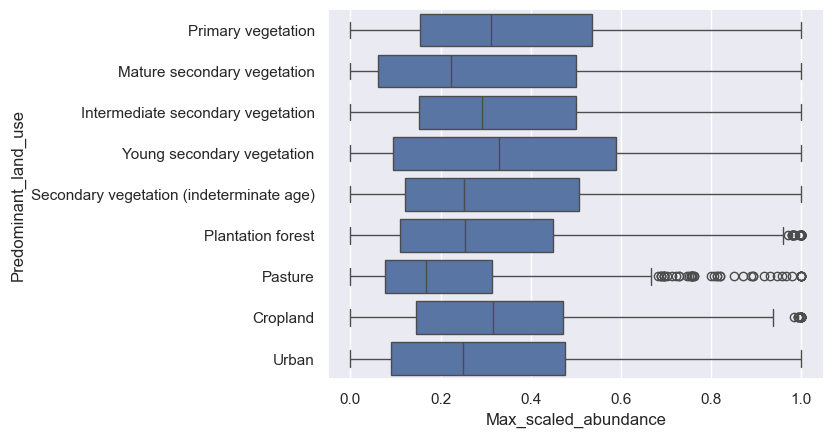

In [126]:
order = [
    "Primary vegetation",
    "Mature secondary vegetation",
    "Intermediate secondary vegetation",
    "Young secondary vegetation",
    "Secondary vegetation (indeterminate age)",
    "Plantation forest",
    "Pasture",
    "Cropland",
    "Urban",
]
sns.boxplot(
    y="Predominant_land_use", x="Max_scaled_abundance", data=df_scope, order=order
);

### Land-use intensity

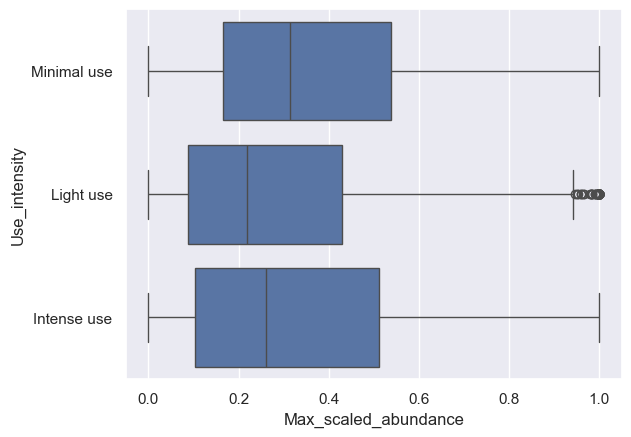

In [127]:
order = [
    "Minimal use",
    "Light use",
    "Intense use",
]
sns.boxplot(y="Use_intensity", x="Max_scaled_abundance", data=df_scope, order=order);

### LUI combinations

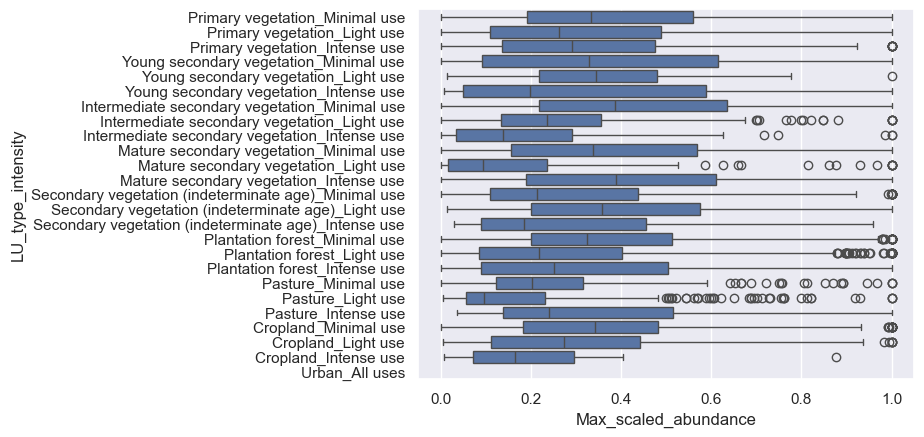

In [128]:
order = [
    "Primary vegetation_Minimal use",
    "Primary vegetation_Light use",
    "Primary vegetation_Intense use",
    "Young secondary vegetation_Minimal use",
    "Young secondary vegetation_Light use",
    "Young secondary vegetation_Intense use",
    "Intermediate secondary vegetation_Minimal use",
    "Intermediate secondary vegetation_Light use",
    "Intermediate secondary vegetation_Intense use",
    "Mature secondary vegetation_Minimal use",
    "Mature secondary vegetation_Light use",
    "Mature secondary vegetation_Intense use",
    "Secondary vegetation (indeterminate age)_Minimal use",
    "Secondary vegetation (indeterminate age)_Light use",
    "Secondary vegetation (indeterminate age)_Intense use",
    "Plantation forest_Minimal use",
    "Plantation forest_Light use",
    "Plantation forest_Intense use",
    "Pasture_Minimal use",
    "Pasture_Light use",
    "Pasture_Intense use",
    "Cropland_Minimal use",
    "Cropland_Light use",
    "Cropland_Intense use",
    "Urban_All uses",
    # "Urban_Minimal use",
    # "Urban_Light use",
    # "Urban_Intense use",
]

sns.boxplot(y="LU_type_intensity", x="Max_scaled_abundance", data=df_scope, order=order);

## Abundance and biogeographic categories

### Biomes

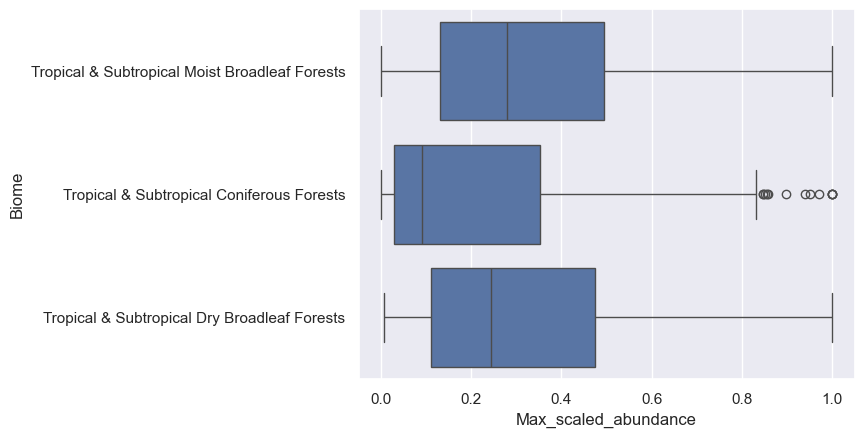

In [129]:
sns.boxplot(y="Biome", x="Max_scaled_abundance", data=df_scope);

### Realms

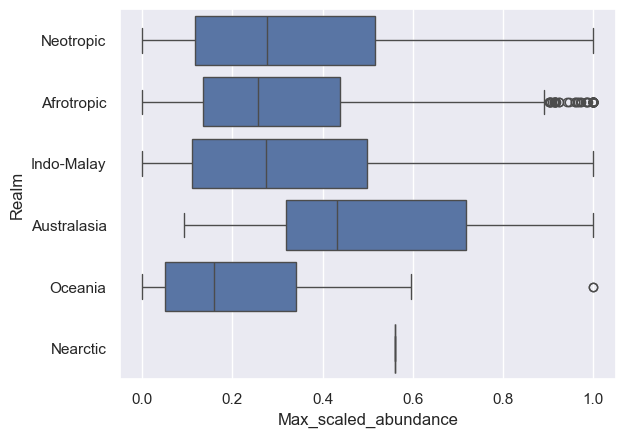

In [130]:
sns.boxplot(y="Realm", x="Max_scaled_abundance", data=df_scope);

### Combined biomes and realms

In [131]:
print(
    df_scope.group_by(["Biome", "Realm"])
    .agg(pl.col("SSBS").count())
    .sort(["Biome", "SSBS"])
)

shape: (11, 3)
┌───────────────────────────────────┬─────────────┬──────┐
│ Biome                             ┆ Realm       ┆ SSBS │
│ ---                               ┆ ---         ┆ ---  │
│ str                               ┆ str         ┆ u32  │
╞═══════════════════════════════════╪═════════════╪══════╡
│ Tropical & Subtropical Coniferou… ┆ Nearctic    ┆ 1    │
│ Tropical & Subtropical Coniferou… ┆ Indo-Malay  ┆ 18   │
│ Tropical & Subtropical Coniferou… ┆ Neotropic   ┆ 270  │
│ Tropical & Subtropical Dry Broad… ┆ Afrotropic  ┆ 82   │
│ Tropical & Subtropical Dry Broad… ┆ Indo-Malay  ┆ 110  │
│ Tropical & Subtropical Dry Broad… ┆ Neotropic   ┆ 411  │
│ Tropical & Subtropical Moist Bro… ┆ Oceania     ┆ 38   │
│ Tropical & Subtropical Moist Bro… ┆ Australasia ┆ 144  │
│ Tropical & Subtropical Moist Bro… ┆ Afrotropic  ┆ 1896 │
│ Tropical & Subtropical Moist Bro… ┆ Indo-Malay  ┆ 2294 │
│ Tropical & Subtropical Moist Bro… ┆ Neotropic   ┆ 2468 │
└───────────────────────────────────┴────

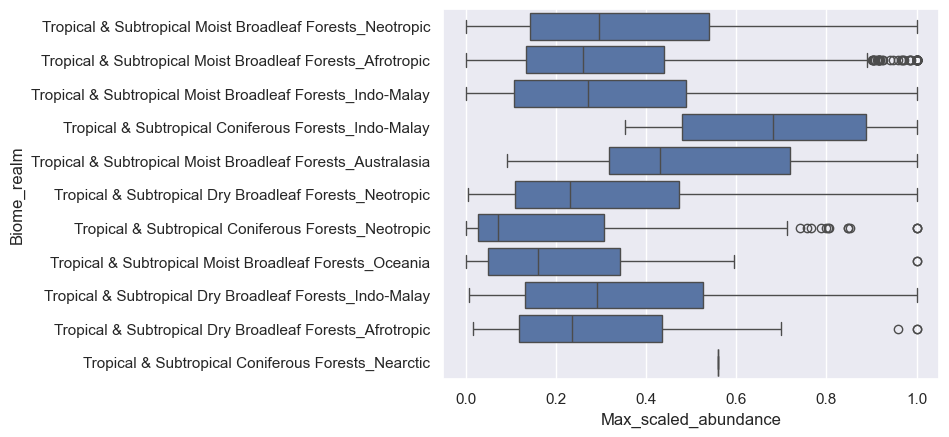

In [132]:
df_scope = df_scope.with_columns(
    pl.concat_str([pl.col("Biome"), pl.col("Realm")], separator="_").alias(
        "Biome_realm"
    )
)
sns.boxplot(y="Biome_realm", x="Max_scaled_abundance", data=df_scope);

### Ecoregions

In [133]:
print(
    df_scope.group_by(["Biome", "Ecoregion"]).agg(pl.col("SSBS").count()).sort(["SSBS"])
)

shape: (118, 3)
┌───────────────────────────────────┬───────────────────────────────────┬──────┐
│ Biome                             ┆ Ecoregion                         ┆ SSBS │
│ ---                               ┆ ---                               ┆ ---  │
│ str                               ┆ str                               ┆ u32  │
╞═══════════════════════════════════╪═══════════════════════════════════╪══════╡
│ Tropical & Subtropical Moist Bro… ┆ Madeira-Tapajós Moist Forests     ┆ 1    │
│ Tropical & Subtropical Moist Bro… ┆ Guianan Piedmont And Lowland Moi… ┆ 1    │
│ Tropical & Subtropical Moist Bro… ┆ Purus Varzeá                      ┆ 1    │
│ Tropical & Subtropical Moist Bro… ┆ Mato Grosso Seasonal Forests      ┆ 1    │
│ Tropical & Subtropical Dry Broad… ┆ Tumbes-Piura Dry Forests          ┆ 1    │
│ Tropical & Subtropical Coniferou… ┆ Sierra Madre Oriental Pine-Oak F… ┆ 1    │
│ Tropical & Subtropical Moist Bro… ┆ Bahia Interior Forests            ┆ 1    │
│ Tropical &

## Biodiversity hotspots and wilderness areas

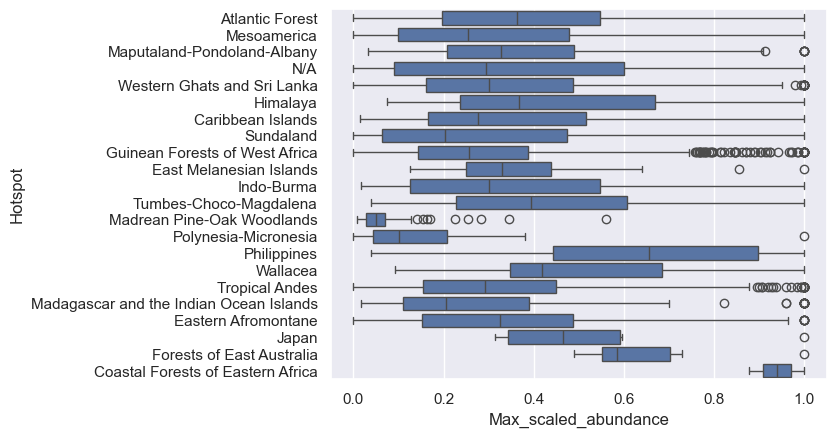

In [134]:
df_scope = df_scope.with_columns(
    pl.when(pl.col("Hotspot").is_null())
    .then(pl.lit("N/A"))
    .otherwise(pl.col("Hotspot"))
    .alias("Hotspot")
)
sns.boxplot(y="Hotspot", x="Max_scaled_abundance", data=df_scope);

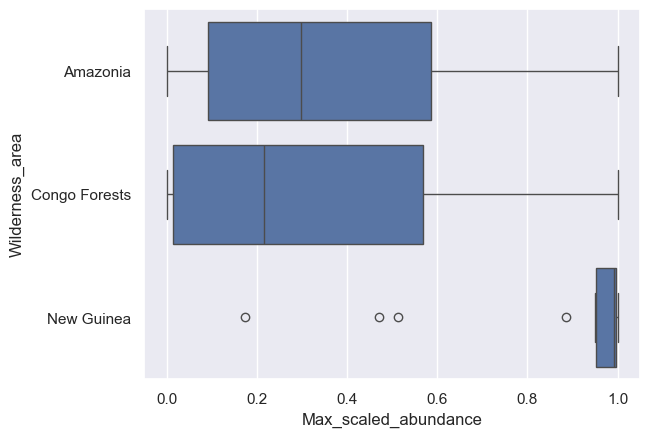

In [135]:
sns.boxplot(y="Wilderness_area", x="Max_scaled_abundance", data=df_scope);

## Correlation with continuous variables

In [136]:
def create_corr_barplot(
    df: pl.DataFrame,
    response: str,
    covariates: list[str],
    group_col: str,
    method: str,
):
    """
    Generate a correlation bar plot to visualize the average correlation of
    features with a dependent variable across different groups.

    Args:
        df: Dataframe containing the dataset with all features.
        features: List of feature column names to calculate correlations.
        dependent_var: The name of the dependent variable column.
        method: Correlation method to use (e.g., 'pearson', 'spearman', 'kendall').
        group_col: The name of the column indicating groups.
    """
    df = df.to_pandas()
    group_correlations = []

    for _, group_df in df.groupby(group_col):
        corr_data = group_df[covariates + [response]]
        corr_matrix = corr_data.corr(method=method)
        corr_values = corr_matrix.loc[:, response].drop(response, errors="ignore")
        group_correlations.append(corr_values)

    # Average correlations across groups and sort
    avg_corr = (
        pd.concat(group_correlations, axis=1).mean(axis=1).sort_values(ascending=False)
    )

    # Create a bar plot for sorted average correlations using Seaborn
    plt.figure(figsize=(6, 6))
    sns.barplot(
        x=avg_corr.values,
        y=avg_corr.index,
        palette="coolwarm_r",
    )
    plt.gca().invert_xaxis()

    # Position the correlation numbers correctly
    for i, val in enumerate(avg_corr.values):
        if val < 0:
            plt.text(val, i, f"{val:.2f}", ha="left", va="center")
        else:
            plt.text(val, i, f"{val:.2f}", ha="right", va="center")

    plt.ylabel("Covariates")
    plt.title(f"Average correlation with {response} ({method})")

    plt.show()

### Road density

/var/folders/pd/qpp_vpcn3wv209_68c5q1_r80000gn/T/ipykernel_5133/2390763331.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


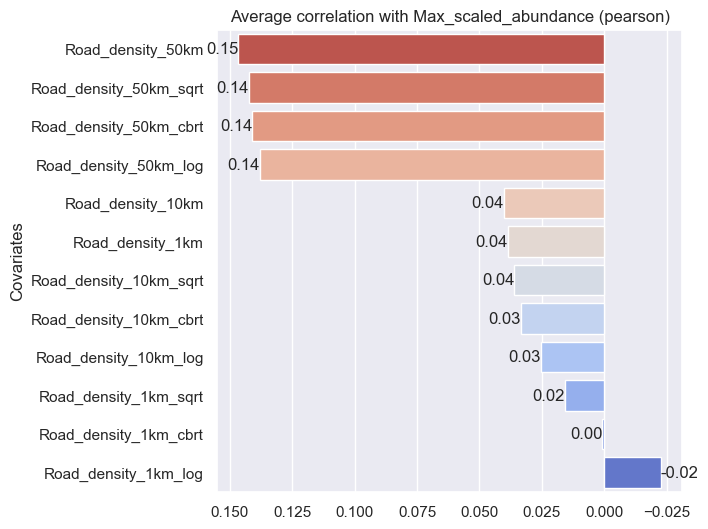

In [137]:
# Select features and generate correlation plot
response = "Max_scaled_abundance"
covariates = [
    "Road_density_1km",
    "Road_density_10km",
    "Road_density_50km",
    "Road_density_1km_log",
    "Road_density_1km_sqrt",
    "Road_density_1km_cbrt",
    "Road_density_10km_log",
    "Road_density_10km_sqrt",
    "Road_density_10km_cbrt",
    "Road_density_50km_log",
    "Road_density_50km_sqrt",
    "Road_density_50km_cbrt",
]
create_corr_barplot(
    df_scope,
    response=response,
    covariates=covariates,
    group_col="Biome_realm",
    method="pearson",
)

### Population density

/var/folders/pd/qpp_vpcn3wv209_68c5q1_r80000gn/T/ipykernel_5133/2390763331.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


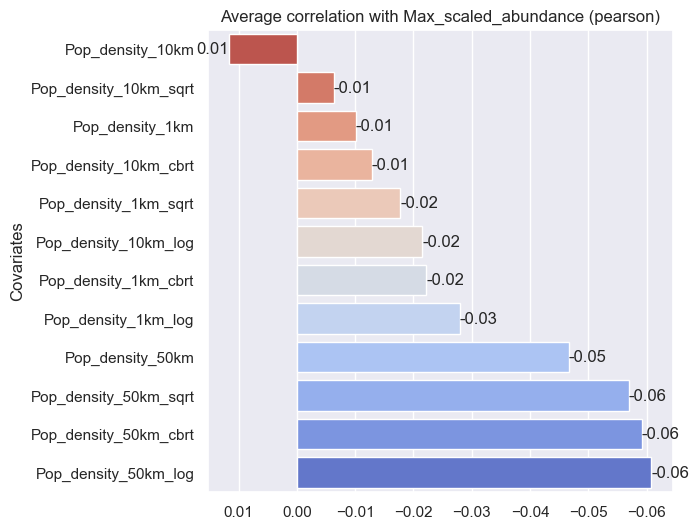

In [138]:
# Select features and generate correlation plot
response = "Max_scaled_abundance"
covariates = [
    "Pop_density_1km",
    "Pop_density_10km",
    "Pop_density_50km",
    "Pop_density_1km_log",
    "Pop_density_1km_sqrt",
    "Pop_density_1km_cbrt",
    "Pop_density_10km_log",
    "Pop_density_10km_sqrt",
    "Pop_density_10km_cbrt",
    "Pop_density_50km_log",
    "Pop_density_50km_sqrt",
    "Pop_density_50km_cbrt",
]
create_corr_barplot(
    df_scope,
    response=response,
    covariates=covariates,
    group_col="Biome_realm",
    method="pearson",
)

### Bioclimatic

/var/folders/pd/qpp_vpcn3wv209_68c5q1_r80000gn/T/ipykernel_5133/2390763331.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


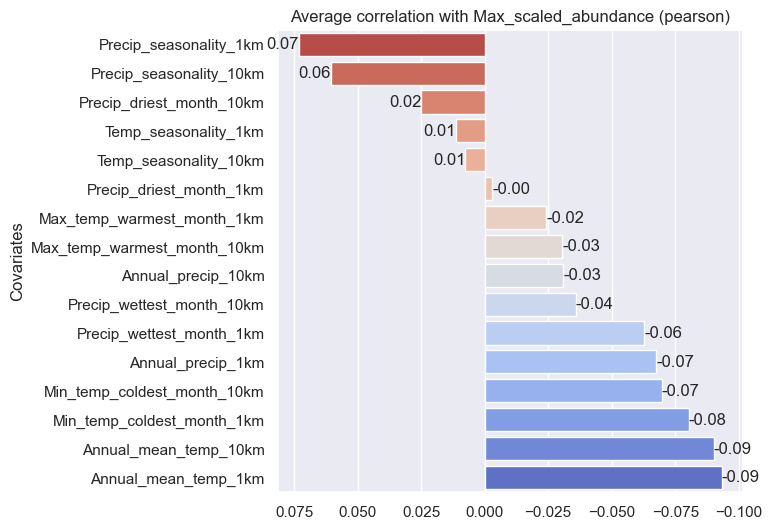

In [139]:
# Select features and generate correlation plot
response = "Max_scaled_abundance"
covariates = [
    "Annual_mean_temp_1km",
    "Temp_seasonality_1km",
    "Max_temp_warmest_month_1km",
    "Min_temp_coldest_month_1km",
    "Annual_precip_1km",
    "Precip_wettest_month_1km",
    "Precip_driest_month_1km",
    "Precip_seasonality_1km",
    "Annual_mean_temp_10km",
    "Temp_seasonality_10km",
    "Max_temp_warmest_month_10km",
    "Min_temp_coldest_month_10km",
    "Annual_precip_10km",
    "Precip_wettest_month_10km",
    "Precip_driest_month_10km",
    "Precip_seasonality_10km",
]
create_corr_barplot(
    df_scope,
    response=response,
    covariates=covariates,
    group_col="Biome_realm",
    method="pearson",
)

### Topographic

/var/folders/pd/qpp_vpcn3wv209_68c5q1_r80000gn/T/ipykernel_5133/2390763331.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


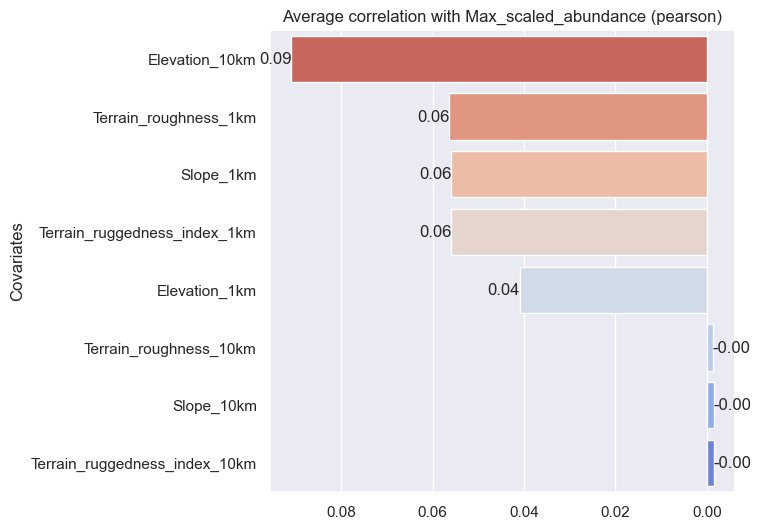

In [165]:
# Select features and generate correlation plot
response = "Max_scaled_abundance"
covariates = [
    "Elevation_1km",
    "Slope_1km",
    "Terrain_roughness_1km",
    "Terrain_ruggedness_index_1km",
    "Elevation_10km",
    "Slope_10km",
    "Terrain_roughness_10km",
    "Terrain_ruggedness_index_10km",
]
create_corr_barplot(
    df_scope,
    response=response,
    covariates=covariates,
    group_col="Biome_realm",
    method="pearson",
)

## Analysis of different response variables

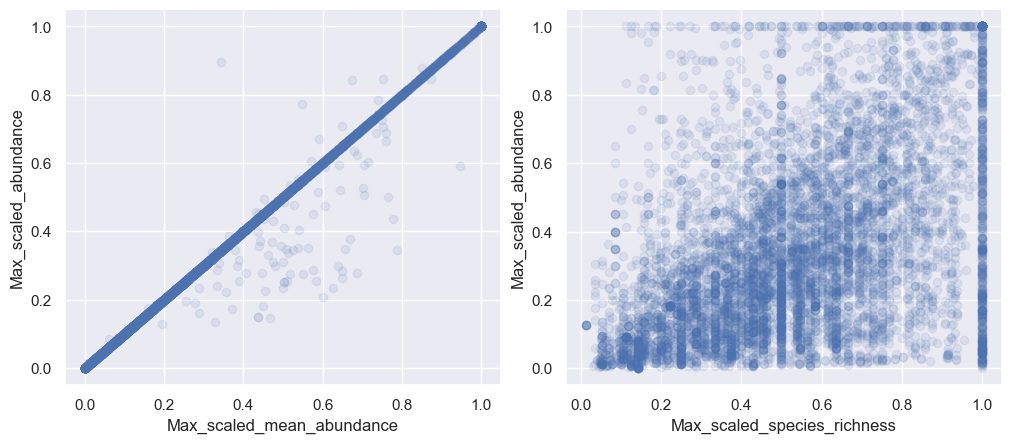

In [140]:
correlation_scatter_plots(
    df_scope,
    response=response_var,
    covariates=["Max_scaled_mean_abundance", "Max_scaled_species_richness"],
)

In [9]:
df_max_abund = (
    df.filter(pl.col("Max_scaled_abundance") == 1)
    .group_by("LU_type_intensity")
    .len()
    .rename({"len": "Max_abund_count"})
)
df_lui_freq = df.group_by("LU_type_intensity").len().rename({"len": "Count"})

df_max_abund = df_max_abund.join(df_lui_freq, on="LU_type_intensity", how="inner")
df_max_abund = df_max_abund.with_columns(
    (pl.col("Max_abund_count") / pl.col("Count")).alias("Scaled_max_freq")
).sort("Scaled_max_freq", descending=True)

In [11]:
sns.set_style("ticks")
plt.rc("figure", titlesize="medium")
plt.rc("font", size=10, family="serif")
plt.rc("axes", titlesize="medium")
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}\usepackage{amssymb}")

/var/folders/pd/qpp_vpcn3wv209_68c5q1_r80000gn/T/ipykernel_10934/3062223513.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


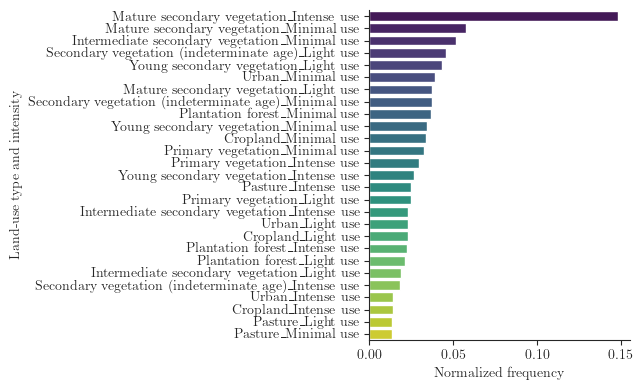

In [25]:
# Convert the Polars DataFrame to a Pandas DataFrame for plotting
# df_max_abund = df_max_abund.to_pandas()

# Create the bar plot with flipped axes
plt.figure(figsize=(6.5, 4))  # Set the figure size as needed
barplot = sns.barplot(
    x="Scaled_max_freq",
    y="LU_type_intensity",
    data=df_max_abund,
    palette="viridis",  # Color palette can be changed as needed
)
sns.despine()
plt.xlabel("Normalized frequency")
plt.ylabel("Land-use type and intensity")
plt.tight_layout()
plt.savefig("../../figures/lui_frequency.pdf")
plt.show()

## Correlation between covariates

In [159]:
def create_corr_heatmap(
    df: pl.DataFrame, features: list[str], group_col: str, method: str
):
    df = df.to_pandas()
    group_correlations = []

    for _, group_df in df.groupby(group_col):
        corr_data = group_df[features].dropna(axis="rows")
        corr_matrix = corr_data.corr(method=method)
        group_correlations.append(corr_matrix)

    # Average correlation matrices across groups
    avg_corr_matrix = pd.concat(group_correlations).groupby(level=0).mean()

    # Create a Seaborn correlation heatmap
    plt.figure(figsize=(8, 4))
    sns.heatmap(avg_corr_matrix, annot=True, cmap="coolwarm")

    plt.title(f"Average Correlation between covariates ({method})")

    plt.show()

### Population and road density

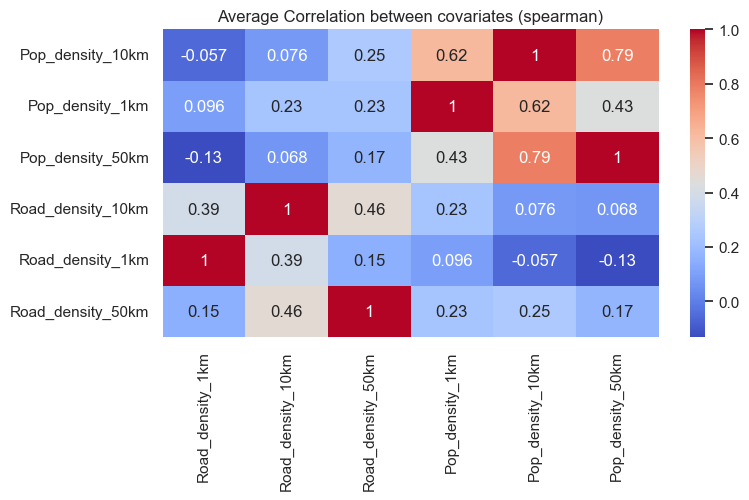

In [160]:
features = [
    "Road_density_1km",
    "Road_density_10km",
    "Road_density_50km",
    "Pop_density_1km",
    "Pop_density_10km",
    "Pop_density_50km",
]
create_corr_heatmap(df_scope, features, "Biome_Realm", method="spearman")

### Bioclimatic

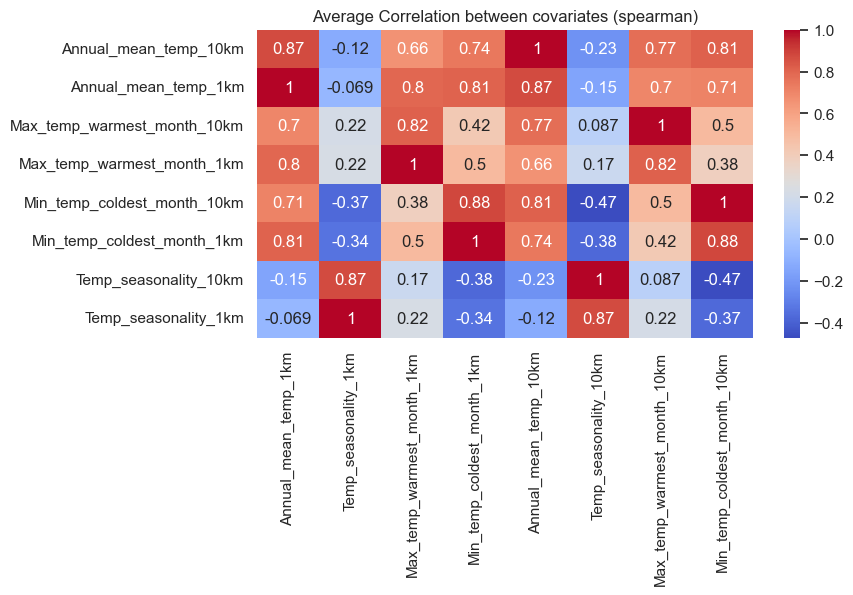

In [162]:
features = [
    "Annual_mean_temp_1km",
    "Temp_seasonality_1km",
    "Max_temp_warmest_month_1km",
    "Min_temp_coldest_month_1km",
    "Annual_mean_temp_10km",
    "Temp_seasonality_10km",
    "Max_temp_warmest_month_10km",
    "Min_temp_coldest_month_10km",
]
create_corr_heatmap(df_scope, features, "Biome_Realm", method="spearman")

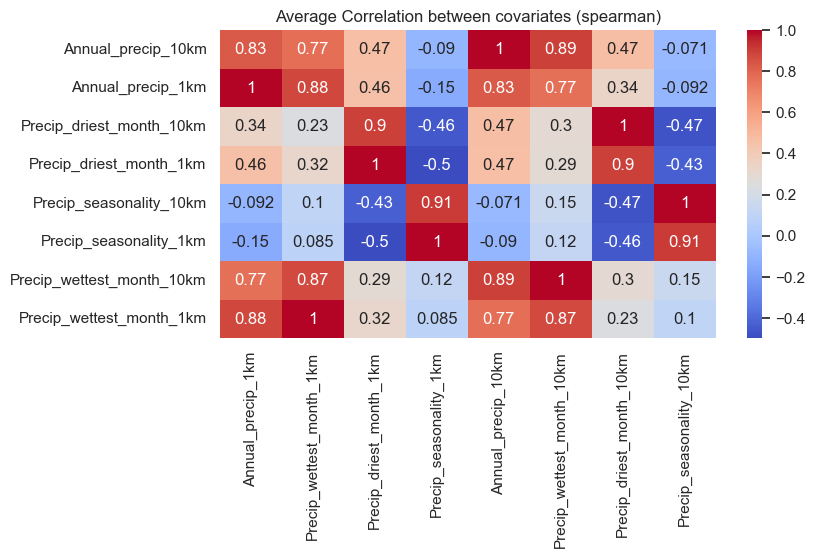

In [163]:
features = [
    "Annual_precip_1km",
    "Precip_wettest_month_1km",
    "Precip_driest_month_1km",
    "Precip_seasonality_1km",
    "Annual_precip_10km",
    "Precip_wettest_month_10km",
    "Precip_driest_month_10km",
    "Precip_seasonality_10km",
]
create_corr_heatmap(df_scope, features, "Biome_Realm", method="spearman")

### Topographic

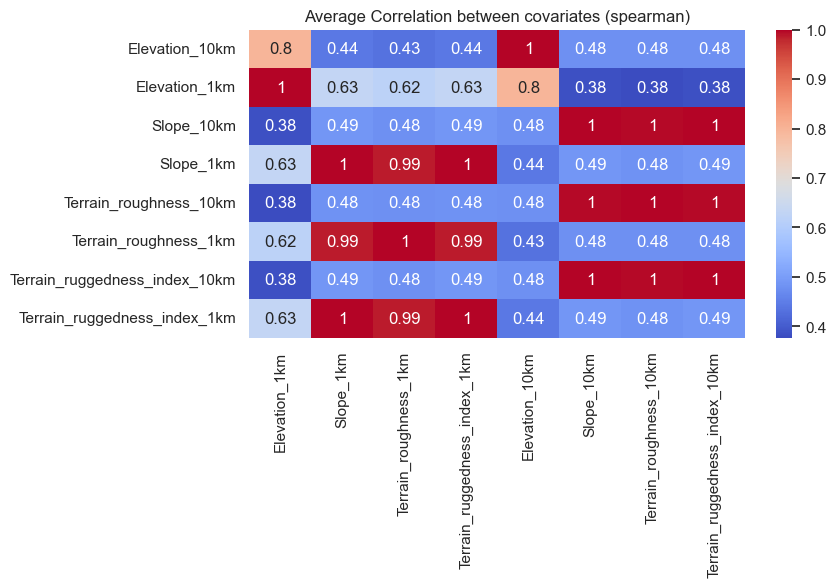

In [166]:
features = [
    "Elevation_1km",
    "Slope_1km",
    "Terrain_roughness_1km",
    "Terrain_ruggedness_index_1km",
    "Elevation_10km",
    "Slope_10km",
    "Terrain_roughness_10km",
    "Terrain_ruggedness_index_10km",
]
create_corr_heatmap(df_scope, features, "Biome_Realm", method="spearman")

## Abundance and road density

### No transformation

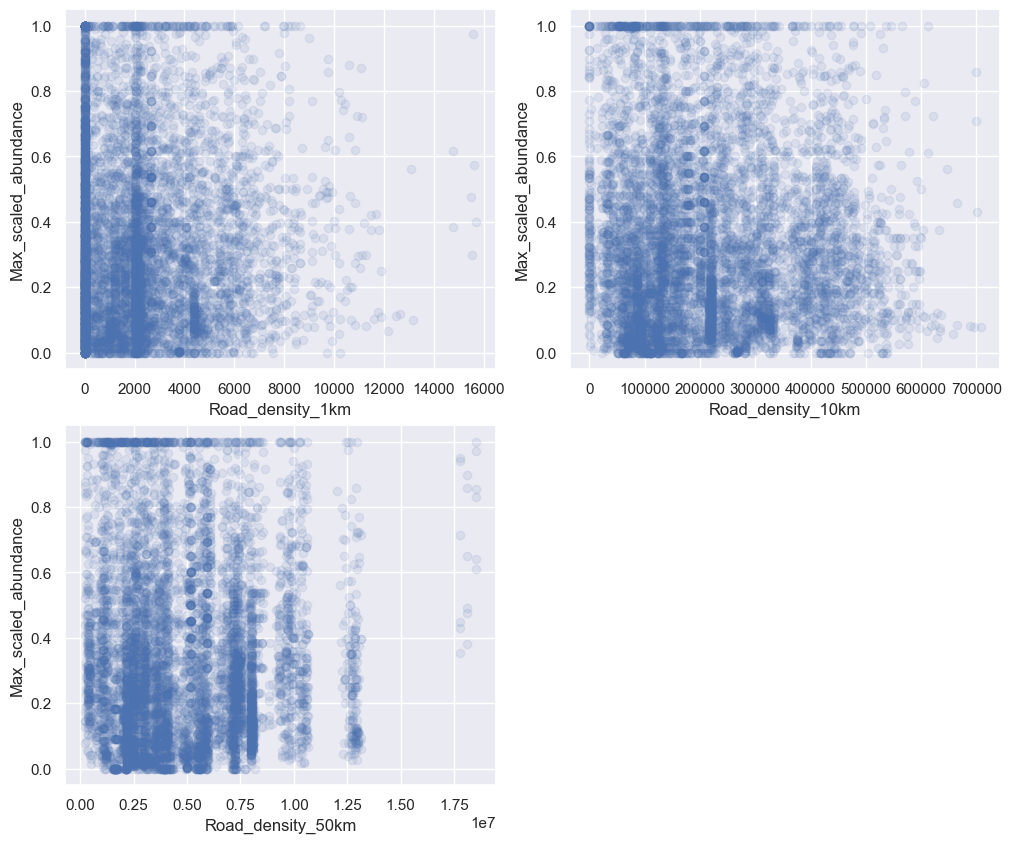

In [143]:
correlation_scatter_plots(
    df_scope,
    response=response_var,
    covariates=["Road_density_1km", "Road_density_10km", "Road_density_50km"],
)

### Log transform

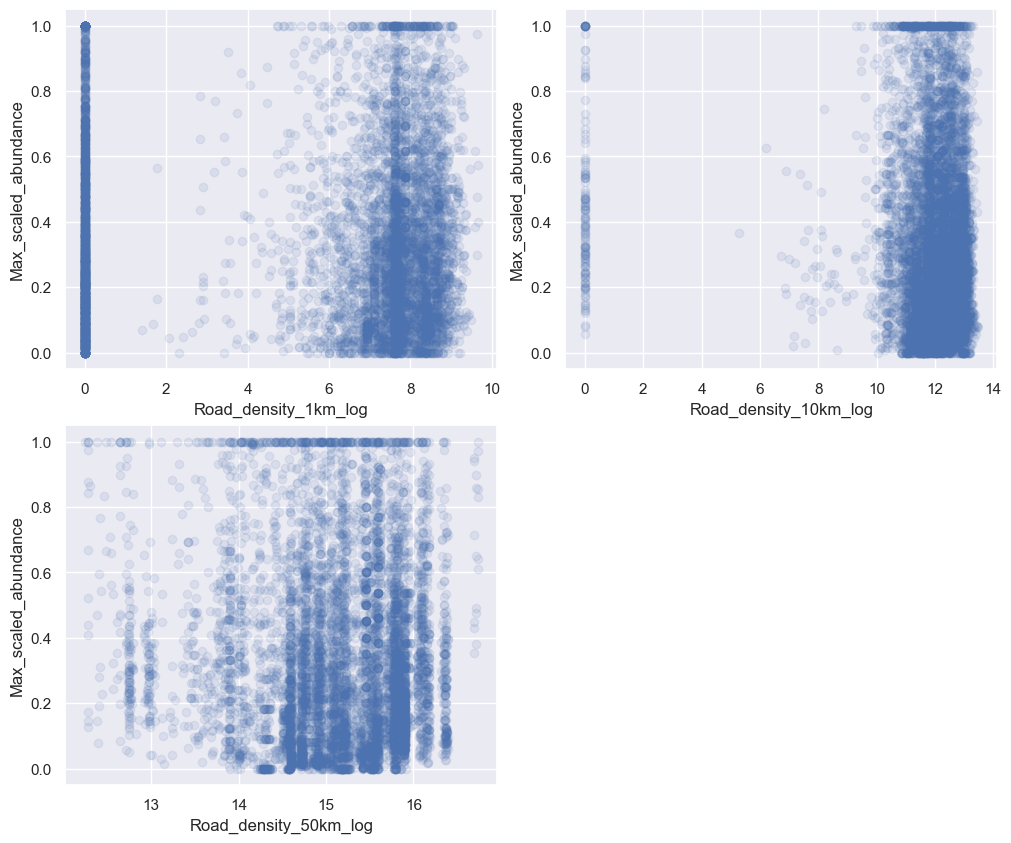

In [144]:
correlation_scatter_plots(
    df_scope,
    response=response_var,
    covariates=[
        "Road_density_1km_log",
        "Road_density_10km_log",
        "Road_density_50km_log",
    ],
)

### Square-root transform

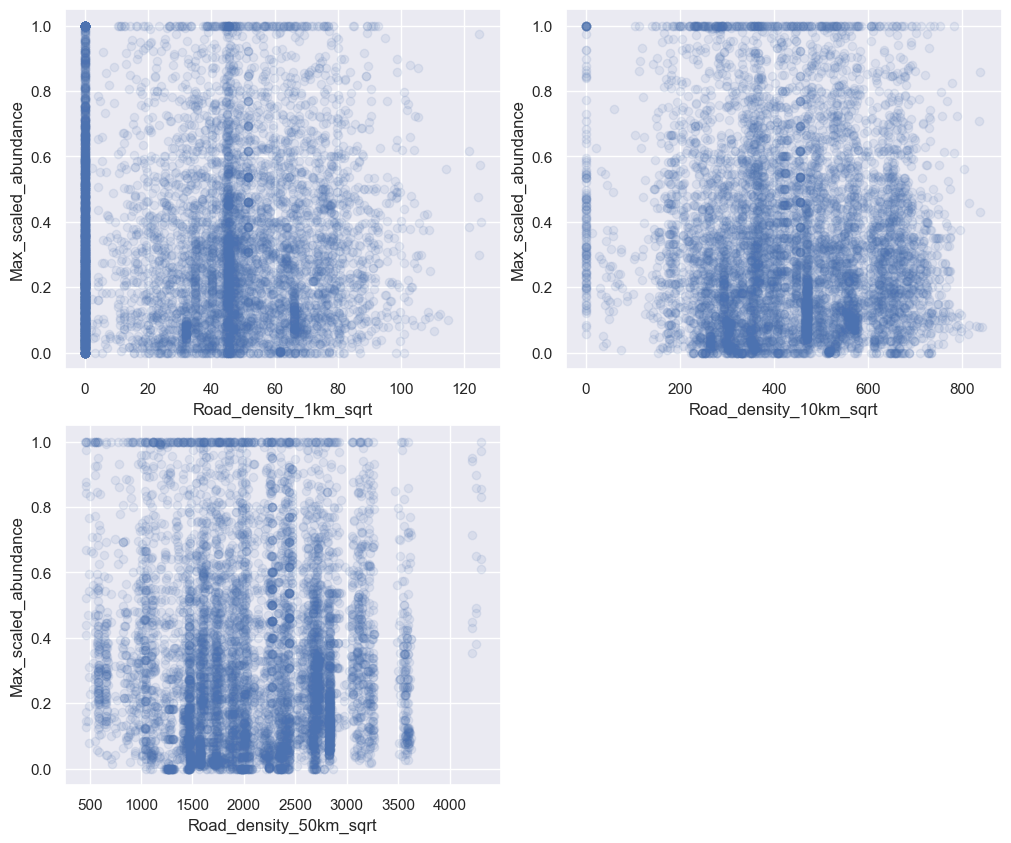

In [145]:
correlation_scatter_plots(
    df_scope,
    response=response_var,
    covariates=[
        "Road_density_1km_sqrt",
        "Road_density_10km_sqrt",
        "Road_density_50km_sqrt",
    ],
)

### Cube-root transform

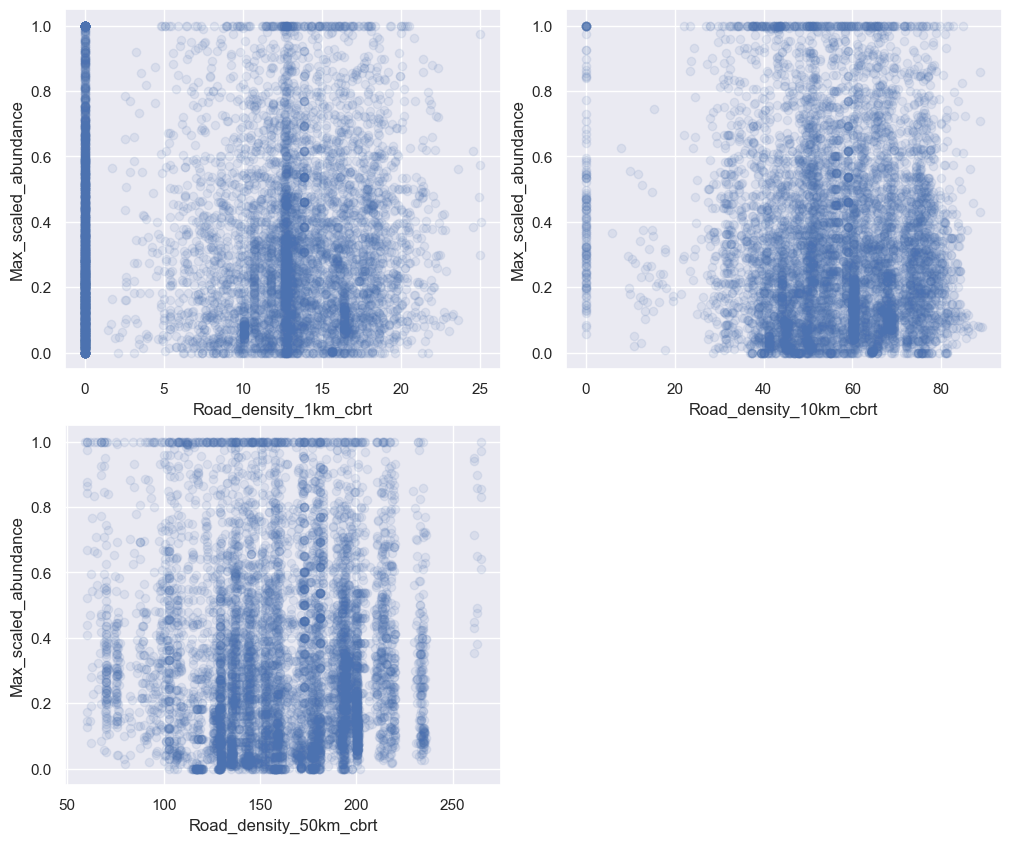

In [146]:
correlation_scatter_plots(
    df_scope,
    response=response_var,
    covariates=[
        "Road_density_1km_cbrt",
        "Road_density_10km_cbrt",
        "Road_density_50km_cbrt",
    ],
)

## Abundance and population density

### No transformation

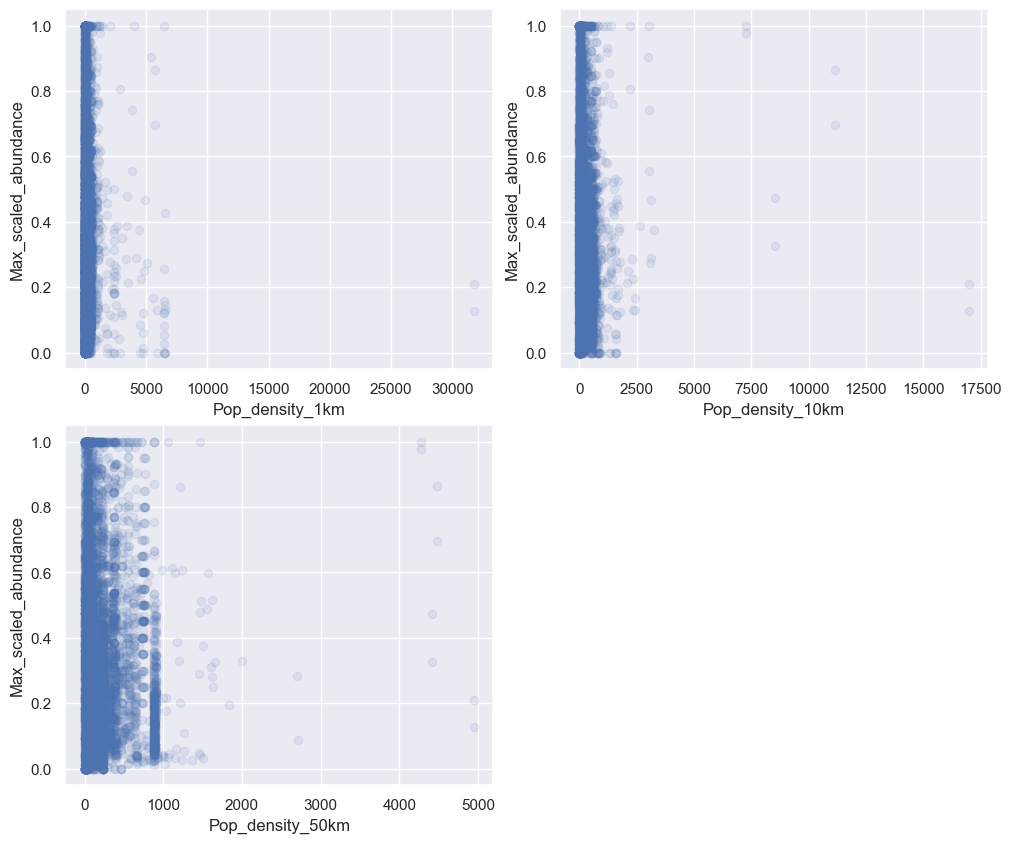

In [147]:
correlation_scatter_plots(
    df_scope,
    response=response_var,
    covariates=["Pop_density_1km", "Pop_density_10km", "Pop_density_50km"],
)

### Log transform

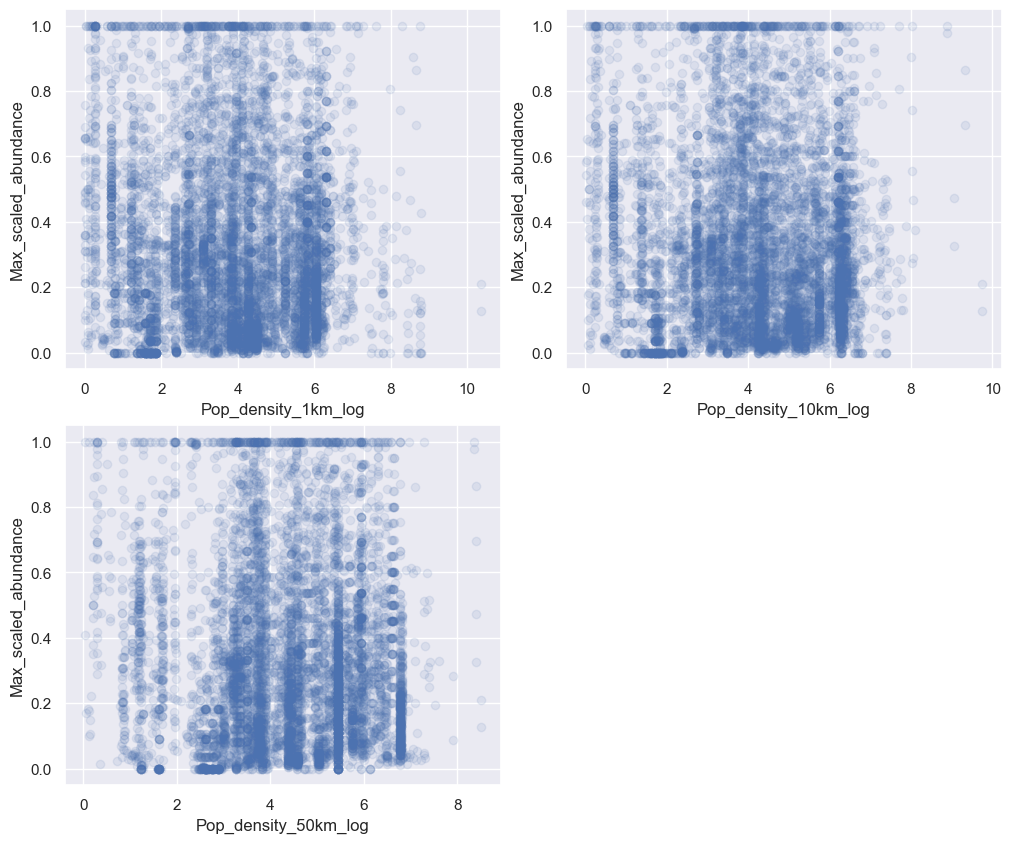

In [148]:
correlation_scatter_plots(
    df_scope,
    response=response_var,
    covariates=["Pop_density_1km_log", "Pop_density_10km_log", "Pop_density_50km_log"],
)

### Square-root transform

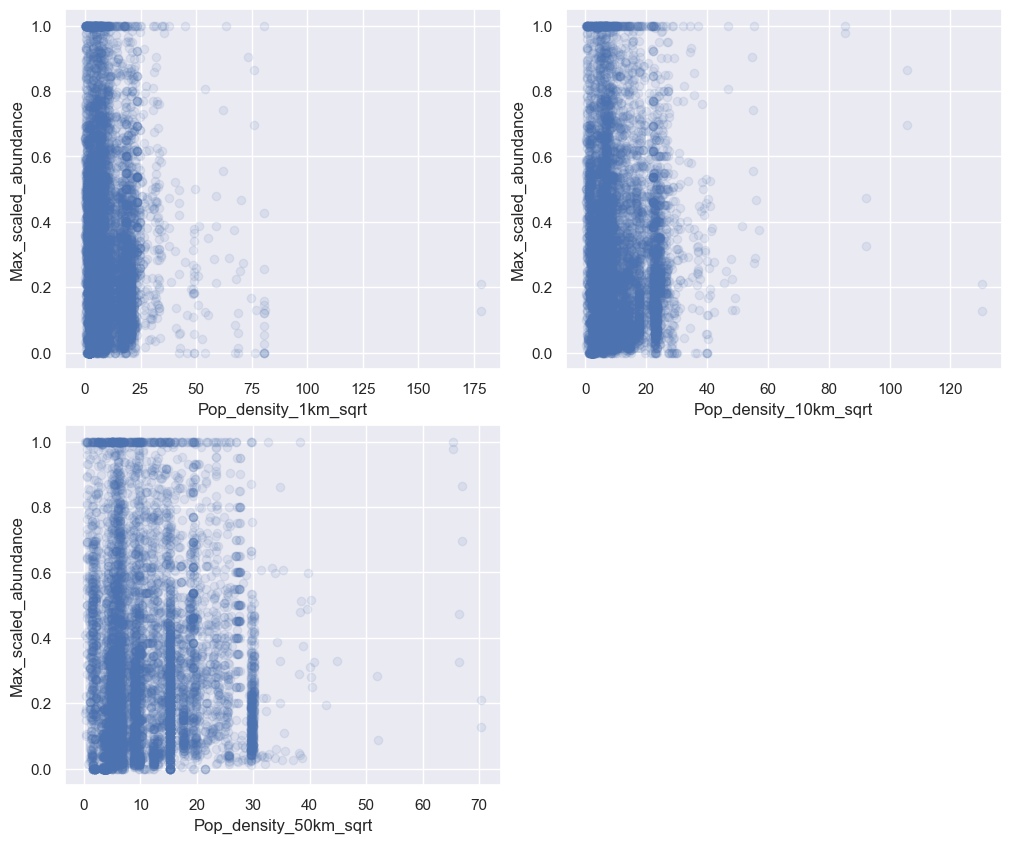

In [149]:
correlation_scatter_plots(
    df_scope,
    response=response_var,
    covariates=[
        "Pop_density_1km_sqrt",
        "Pop_density_10km_sqrt",
        "Pop_density_50km_sqrt",
    ],
)

### Cube-root transform

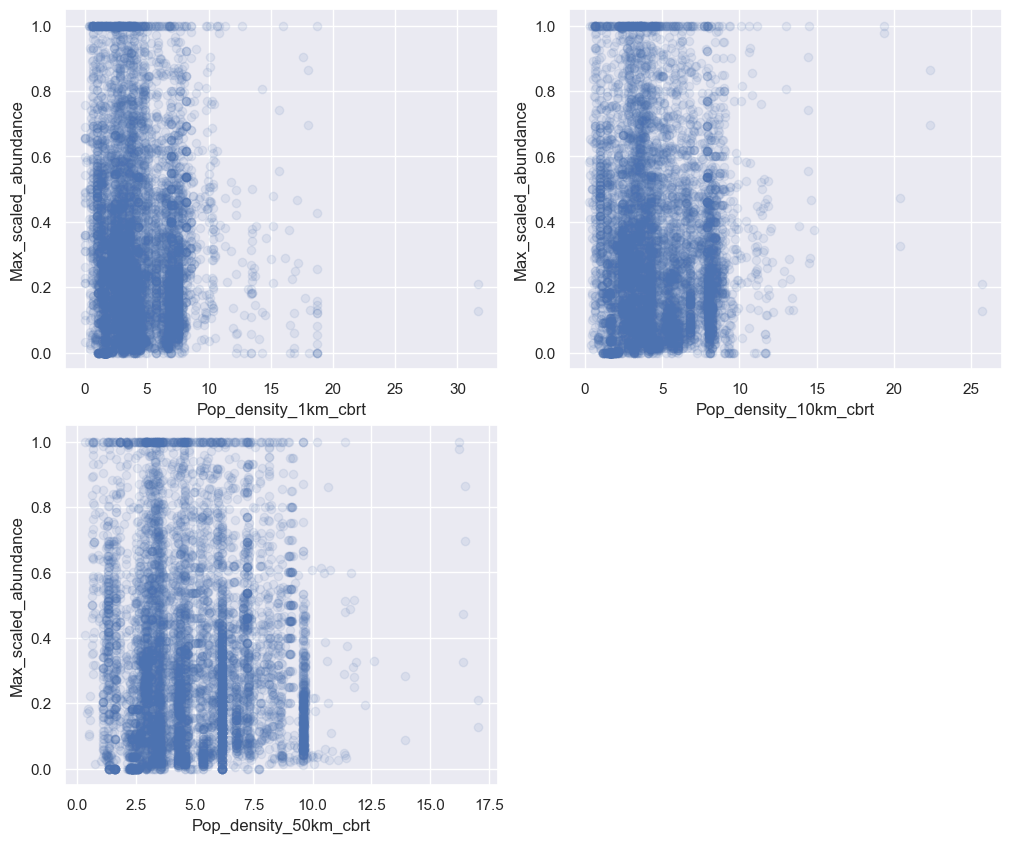

In [150]:
correlation_scatter_plots(
    df_scope,
    response=response_var,
    covariates=[
        "Pop_density_1km_cbrt",
        "Pop_density_10km_cbrt",
        "Pop_density_50km_cbrt",
    ],
)